In [2]:
# %% [markdown]
# # 🏆 Confronto Prestazioni Modelli YOLO Pre-Addestrati
# 
# Questo notebook confronta le prestazioni di 3 modelli YOLO già addestrati per il riconoscimento delle cadute.
# 
# ## 📋 Modelli da confrontare:
# 1. **Modello 1** - YOLOv11n 
# 2. **Modello 2** - YOLOv11s
# 3. **Modello 3** - YOLOv11m o versione custom

# %% [markdown]
# ## 1. Setup e Import

# %%
# Installazione pacchetti necessari
!pip install ultralytics>=8.1.0
!pip install pandas numpy matplotlib seaborn
!pip install scikit-learn
!pip install tabulate
!pip install tqdm

# %%
import os
import time
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from ultralytics import YOLO
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tabulate import tabulate
from tqdm import tqdm
import cv2
import warnings
warnings.filterwarnings('ignore')

# Configurazione matplotlib
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")

zsh:1: 8.1.0 not found


In [3]:

# %% [markdown]
# ## 2. Configurazione

# %%
# MODIFICA QUESTI PATH CON I TUOI
CONFIG = {
    'models': {
        'model1_the_hystory': '/Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/1. fallen_people_detection/fpds_minimal/weights/best.pt',  # MODIFICA
        'model2_kiko_è_nano': '/Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/2. Pierga_eof_YOLO/v8nfirst/v8n_dataset_pierga.pt',  # MODIFICA
        'thelastdance_11': '/Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/3. fallen_people_detection/best_fall_detection_yolo11.pt',  # MODIFICA
    },
    'test_data': {
        'images_path': '/Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/augmented_yolo_dataset/images/test',  # MODIFICA
        'labels_path': '/Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/augmented_yolo_dataset/labels/test',  # MODIFICA
    },
    'evaluation_params': {
        'conf_threshold': 0.25,
        'iou_threshold': 0.45,
        'batch_size': 16,
        'device': 'cpu'
    },
    'class_names': {
        0: 'not_fallen',
        1: 'fallen'
    }
}

# Directory per salvare i risultati
RESULTS_DIR = Path('model_evaluation_results')
RESULTS_DIR.mkdir(exist_ok=True)

print("✅ Configurazione completata")
print(f"📊 Modelli da confrontare: {list(CONFIG['models'].keys())}")
print(f"📁 Test images: {CONFIG['test_data']['images_path']}")

✅ Configurazione completata
📊 Modelli da confrontare: ['model1_the_hystory', 'model2_kiko_è_nano', 'thelastdance_11']
📁 Test images: /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/augmented_yolo_dataset/images/test


In [4]:
# %% [markdown]
# ## 3. Funzioni di Valutazione

# %%
def evaluate_model_performance(model_name, model_path, test_images_path, test_labels_path, config):
    """Valuta completamente un modello pre-addestrato"""
    
    print(f"\n{'='*60}")
    print(f"📊 Valutando: {model_name}")
    print(f"{'='*60}")
    
    results = {
        'model_name': model_name,
        'model_path': model_path
    }
    
    # Verifica che il modello esista
    if not Path(model_path).exists():
        print(f"❌ Modello non trovato: {model_path}")
        return None
    
    # Carica modello
    print(f"📦 Caricando modello...")
    model = YOLO(model_path)
    
    # 1. Test su tutto il dataset
    print(f"🔍 Valutazione su test set...")
    test_images = list(Path(test_images_path).glob('*.jpg'))
    test_labels = Path(test_labels_path)
    
    # Inizializza metriche
    all_predictions = []
    all_ground_truths = []
    all_confidences = []
    inference_times = []
    
    # Progress bar
    for img_path in tqdm(test_images, desc="Processing images"):
        # Ground truth
        label_path = test_labels / (img_path.stem + '.txt')
        ground_truth = []
        
        if label_path.exists():
            with open(label_path, 'r') as f:
                for line in f:
                    if line.strip():
                        class_id = int(line.strip().split()[0])
                        ground_truth.append(class_id)
        
        # Predizione con timing
        start_time = time.time()
        predictions = model.predict(
            source=str(img_path),
            conf=config['evaluation_params']['conf_threshold'],
            iou=config['evaluation_params']['iou_threshold'],
            device=config['evaluation_params']['device'],
            verbose=False
        )
        inference_time = time.time() - start_time
        inference_times.append(inference_time)
        
        # Estrai predizioni
        pred_classes = []
        pred_confidences = []
        
        for pred in predictions:
            if pred.boxes is not None:
                for box in pred.boxes:
                    pred_classes.append(int(box.cls))
                    pred_confidences.append(float(box.conf))
        
        # Salva per metriche (semplificato per demo)
        if ground_truth and pred_classes:
            all_ground_truths.append(ground_truth[0])
            all_predictions.append(pred_classes[0])
            all_confidences.append(pred_confidences[0])
        elif ground_truth and not pred_classes:
            all_ground_truths.append(ground_truth[0])
            all_predictions.append(-1)  # Non rilevato
            all_confidences.append(0.0)
    
    # 2. Calcola metriche
    print(f"\n📈 Calcolando metriche...")
    
    # Filtra non rilevati per metriche standard
    valid_indices = [i for i, pred in enumerate(all_predictions) if pred != -1]
    valid_gt = [all_ground_truths[i] for i in valid_indices]
    valid_pred = [all_predictions[i] for i in valid_indices]
    
    # Classification report
    if valid_gt and valid_pred:
        report = classification_report(
            valid_gt, 
            valid_pred,
            target_names=['not_fallen', 'fallen'],
            output_dict=True
        )
        
        # Estrai metriche principali
        results['metrics'] = {
            'accuracy': report['accuracy'],
            'precision_not_fallen': report['not_fallen']['precision'],
            'recall_not_fallen': report['not_fallen']['recall'],
            'f1_not_fallen': report['not_fallen']['f1-score'],
            'precision_fallen': report['fallen']['precision'],
            'recall_fallen': report['fallen']['recall'],
            'f1_fallen': report['fallen']['f1-score'],
            'macro_precision': report['macro avg']['precision'],
            'macro_recall': report['macro avg']['recall'],
            'macro_f1': report['macro avg']['f1-score']
        }
        
        # Confusion Matrix
        cm = confusion_matrix(valid_gt, valid_pred)
        results['confusion_matrix'] = cm.tolist()
    
    # 3. Metriche di velocità
    results['speed_metrics'] = {
        'mean_inference_time': np.mean(inference_times),
        'std_inference_time': np.std(inference_times),
        'min_inference_time': np.min(inference_times),
        'max_inference_time': np.max(inference_times),
        'fps': 1.0 / np.mean(inference_times) if np.mean(inference_times) > 0 else 0,
        'total_images': len(test_images),
        'detection_rate': len(valid_indices) / len(all_ground_truths) if all_ground_truths else 0
    }
    
    # 4. Dimensione modello
    model_size_mb = Path(model_path).stat().st_size / (1024 * 1024)
    results['model_size_mb'] = model_size_mb
    
    # 5. Analisi errori
    false_negatives = sum(1 for pred in all_predictions if pred == -1)
    results['error_analysis'] = {
        'false_negative_count': false_negatives,
        'false_negative_rate': false_negatives / len(all_predictions) if all_predictions else 0,
        'total_predictions': len(all_predictions)
    }
    
    print(f"✅ Valutazione completata per {model_name}")
    print(f"   • Accuracy: {results['metrics']['accuracy']:.3f}")
    print(f"   • FPS: {results['speed_metrics']['fps']:.2f}")
    print(f"   • Model size: {model_size_mb:.1f} MB")
    
    return results

In [5]:
# %% [markdown]
# ## 4. Valutazione di Tutti i Modelli

# %%
# Valuta tutti i modelli
all_results = {}

for model_name, model_path in CONFIG['models'].items():
    try:
        results = evaluate_model_performance(
            model_name=model_name,
            model_path=model_path,
            test_images_path=CONFIG['test_data']['images_path'],
            test_labels_path=CONFIG['test_data']['labels_path'],
            config=CONFIG
        )
        
        if results:
            all_results[model_name] = results
            
            # Salva risultati individuali
            with open(RESULTS_DIR / f'{model_name}_evaluation.json', 'w') as f:
                json.dump(results, f, indent=2)
    
    except Exception as e:
        print(f"❌ Errore con {model_name}: {str(e)}")
        all_results[model_name] = {'error': str(e)}

print("\n✅ Valutazione completata per tutti i modelli!")



📊 Valutando: model1_the_hystory
📦 Caricando modello...
🔍 Valutazione su test set...


Processing images: 100%|██████████| 802/802 [00:24<00:00, 32.40it/s]



📈 Calcolando metriche...
✅ Valutazione completata per model1_the_hystory
   • Accuracy: 0.977
   • FPS: 33.24
   • Model size: 5.2 MB

📊 Valutando: model2_kiko_è_nano
📦 Caricando modello...
🔍 Valutazione su test set...


Processing images: 100%|██████████| 802/802 [00:38<00:00, 20.89it/s]



📈 Calcolando metriche...
✅ Valutazione completata per model2_kiko_è_nano
   • Accuracy: 0.983
   • FPS: 21.28
   • Model size: 17.6 MB

📊 Valutando: thelastdance_11
📦 Caricando modello...
🔍 Valutazione su test set...


Processing images: 100%|██████████| 802/802 [00:38<00:00, 21.05it/s]


📈 Calcolando metriche...
✅ Valutazione completata per thelastdance_11
   • Accuracy: 0.986
   • FPS: 21.42
   • Model size: 5.2 MB

✅ Valutazione completata per tutti i modelli!


In [6]:
# %% [markdown]
# ## 5. Confronto Risultati

# %%
# Crea DataFrame comparativo
comparison_data = []

for model_name, results in all_results.items():
    if 'error' not in results and 'metrics' in results:
        row = {
            'Model': model_name,
            'Accuracy': results['metrics']['accuracy'],
            'Precision (avg)': results['metrics']['macro_precision'],
            'Recall (avg)': results['metrics']['macro_recall'],
            'F1-Score (avg)': results['metrics']['macro_f1'],
            'F1 not_fallen': results['metrics']['f1_not_fallen'],
            'F1 fallen': results['metrics']['f1_fallen'],
            'FPS': results['speed_metrics']['fps'],
            'Inference Time (ms)': results['speed_metrics']['mean_inference_time'] * 1000,
            'Model Size (MB)': results['model_size_mb'],
            'Detection Rate': results['speed_metrics']['detection_rate']
        }
        comparison_data.append(row)

df_comparison = pd.DataFrame(comparison_data)

# Mostra tabella comparativa
print("\n📊 TABELLA COMPARATIVA MODELLI")
print("="*120)
print(tabulate(df_comparison, headers='keys', tablefmt='grid', floatfmt=".3f"))

# Salva CSV
df_comparison.to_csv(RESULTS_DIR / 'model_comparison.csv', index=False)


📊 TABELLA COMPARATIVA MODELLI
+----+--------------------+------------+-------------------+----------------+------------------+-----------------+-------------+--------+-----------------------+-------------------+------------------+
|    | Model              |   Accuracy |   Precision (avg) |   Recall (avg) |   F1-Score (avg) |   F1 not_fallen |   F1 fallen |    FPS |   Inference Time (ms) |   Model Size (MB) |   Detection Rate |
+====+====================+============+===================+================+==================+=================+=============+========+=======================+===================+==================+
|  0 | model1_the_hystory |      0.977 |             0.977 |          0.977 |            0.977 |           0.978 |       0.977 | 33.241 |                30.083 |             5.186 |            0.994 |
+----+--------------------+------------+-------------------+----------------+------------------+-----------------+-------------+--------+-----------------------+----

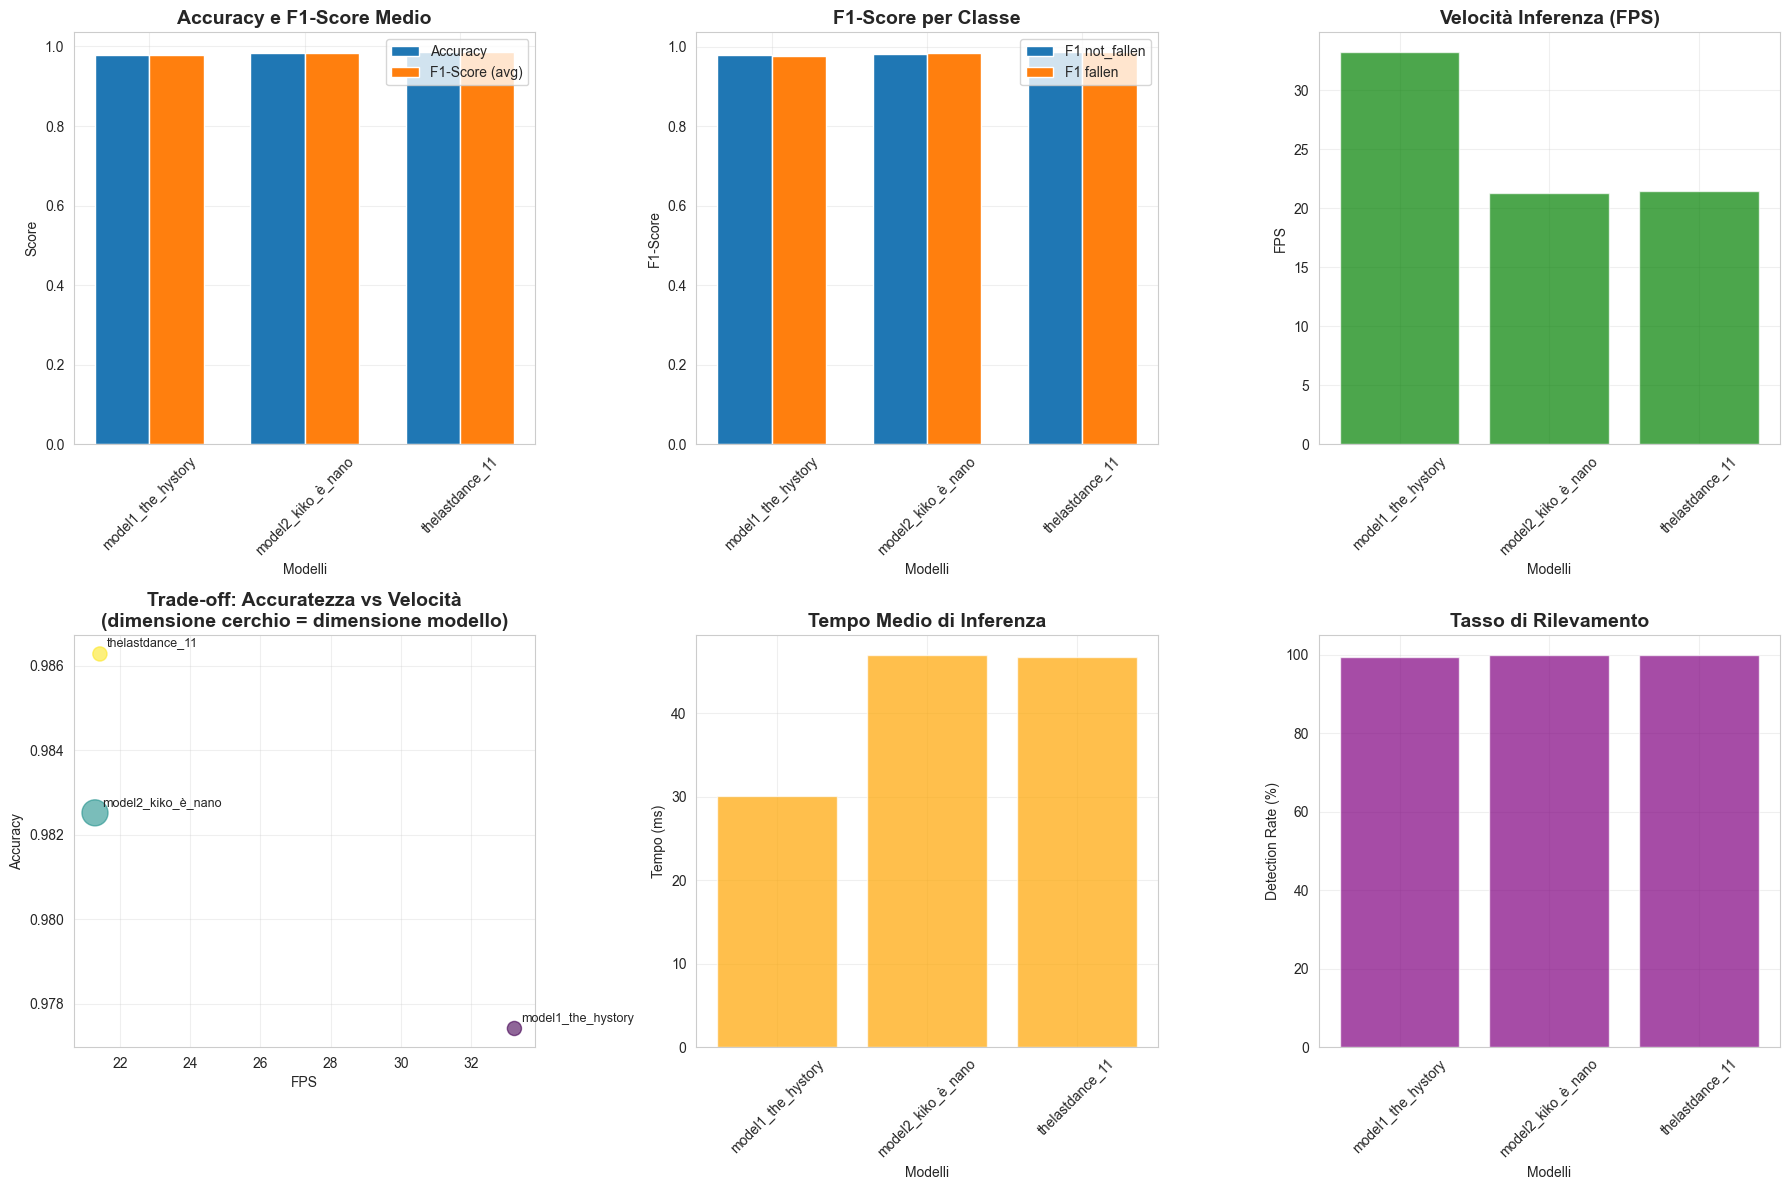

In [7]:
# %% [markdown]
# ## 6. Visualizzazioni Comparative

# %%
# Crea visualizzazioni
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Accuracy e F1-Score
ax = axes[0, 0]
metrics = ['Accuracy', 'F1-Score (avg)']
x = np.arange(len(df_comparison))
width = 0.35

for i, metric in enumerate(metrics):
    values = df_comparison[metric].values
    ax.bar(x + i*width, values, width, label=metric)

ax.set_xlabel('Modelli')
ax.set_ylabel('Score')
ax.set_title('Accuracy e F1-Score Medio', fontsize=14, fontweight='bold')
ax.set_xticks(x + width/2)
ax.set_xticklabels(df_comparison['Model'], rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)

# 2. F1-Score per classe
ax = axes[0, 1]
metrics = ['F1 not_fallen', 'F1 fallen']
x = np.arange(len(df_comparison))
width = 0.35

for i, metric in enumerate(metrics):
    values = df_comparison[metric].values
    ax.bar(x + i*width, values, width, label=metric)

ax.set_xlabel('Modelli')
ax.set_ylabel('F1-Score')
ax.set_title('F1-Score per Classe', fontsize=14, fontweight='bold')
ax.set_xticks(x + width/2)
ax.set_xticklabels(df_comparison['Model'], rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Velocità (FPS)
ax = axes[0, 2]
ax.bar(df_comparison['Model'], df_comparison['FPS'], color='green', alpha=0.7)
ax.set_xlabel('Modelli')
ax.set_ylabel('FPS')
ax.set_title('Velocità Inferenza (FPS)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# 4. Trade-off: Accuracy vs Speed
ax = axes[1, 0]
scatter = ax.scatter(df_comparison['FPS'], 
                    df_comparison['Accuracy'], 
                    s=df_comparison['Model Size (MB)'] * 20,  # Dimensione proporzionale
                    alpha=0.6,
                    c=range(len(df_comparison)),
                    cmap='viridis')

for i, model in enumerate(df_comparison['Model']):
    ax.annotate(model, 
                (df_comparison['FPS'].iloc[i], df_comparison['Accuracy'].iloc[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

ax.set_xlabel('FPS')
ax.set_ylabel('Accuracy')
ax.set_title('Trade-off: Accuratezza vs Velocità\n(dimensione cerchio = dimensione modello)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# 5. Tempo di inferenza
ax = axes[1, 1]
ax.bar(df_comparison['Model'], df_comparison['Inference Time (ms)'], color='orange', alpha=0.7)
ax.set_xlabel('Modelli')
ax.set_ylabel('Tempo (ms)')
ax.set_title('Tempo Medio di Inferenza', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# 6. Detection Rate
ax = axes[1, 2]
ax.bar(df_comparison['Model'], df_comparison['Detection Rate'] * 100, color='purple', alpha=0.7)
ax.set_xlabel('Modelli')
ax.set_ylabel('Detection Rate (%)')
ax.set_title('Tasso di Rilevamento', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'model_comparison_plots.png', dpi=300, bbox_inches='tight')
plt.show()



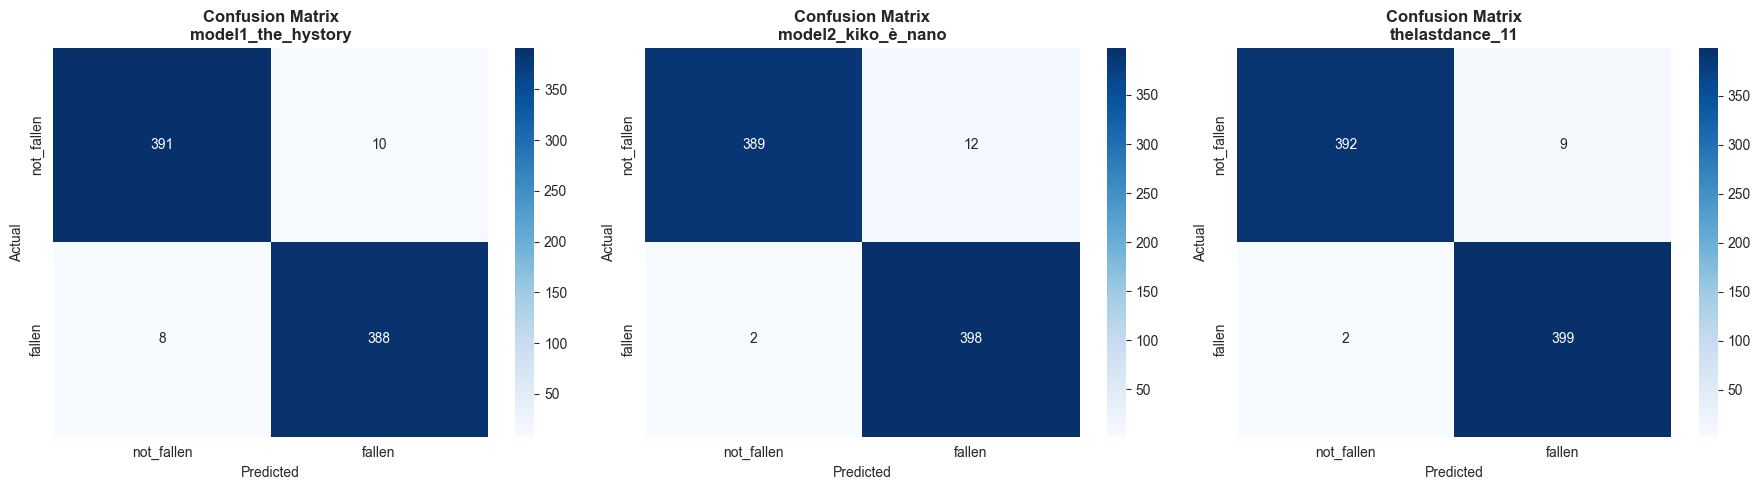

In [8]:
# %% [markdown]
# ## 7. Confusion Matrix per Ogni Modello

# %%
# Visualizza confusion matrix per ogni modello
fig, axes = plt.subplots(1, len(all_results), figsize=(6*len(all_results), 5))
if len(all_results) == 1:
    axes = [axes]

for idx, (model_name, results) in enumerate(all_results.items()):
    if 'confusion_matrix' in results:
        cm = np.array(results['confusion_matrix'])
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['not_fallen', 'fallen'],
                   yticklabels=['not_fallen', 'fallen'],
                   ax=axes[idx])
        axes[idx].set_title(f'Confusion Matrix\n{model_name}', fontweight='bold')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()



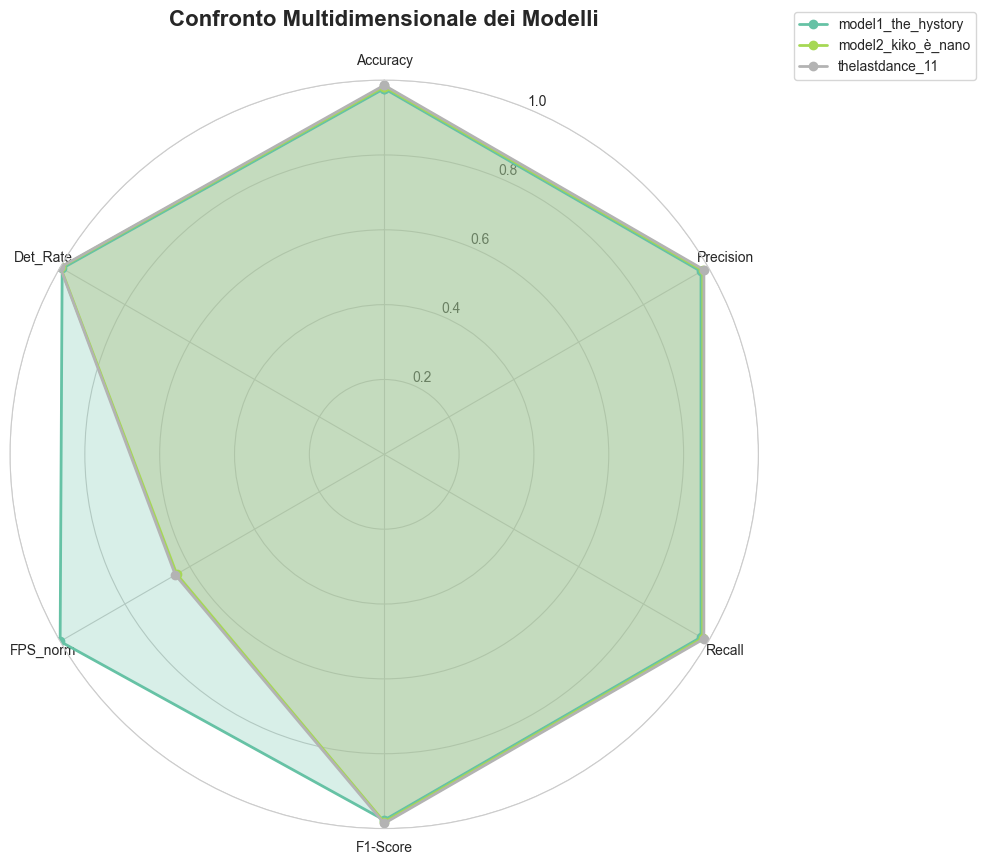

In [9]:
# %% [markdown]
# ## 8. Radar Chart Comparativo

# %%
# Prepara dati per radar chart
categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'FPS_norm', 'Det_Rate']

# Normalizza alcune metriche per il radar (0-1)
df_radar = df_comparison.copy()
df_radar['FPS_norm'] = df_radar['FPS'] / df_radar['FPS'].max()
df_radar['Det_Rate'] = df_radar['Detection Rate']

# Crea radar chart
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='polar')

angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

colors = plt.cm.Set2(np.linspace(0, 1, len(df_comparison)))

for idx, row in df_radar.iterrows():
    values = [
        row['Accuracy'],
        row['Precision (avg)'],
        row['Recall (avg)'],
        row['F1-Score (avg)'],
        row['FPS_norm'],
        row['Det_Rate']
    ]
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, 
            label=row['Model'], color=colors[idx])
    ax.fill(angles, values, alpha=0.25, color=colors[idx])

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_ylim(0, 1)
ax.set_title('Confronto Multidimensionale dei Modelli', 
             fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'radar_comparison.png', dpi=300, bbox_inches='tight')
plt.show()



In [10]:
# %% [markdown]
# ## 9. Analisi del Miglior Modello

# %%
# Determina il miglior modello secondo diversi criteri
print("\n🏆 ANALISI MIGLIOR MODELLO")
print("="*60)

criteria = {}

# Calcola vincitori per ogni criterio
if not df_comparison.empty:
    criteria['Miglior Accuracy'] = df_comparison.loc[df_comparison['Accuracy'].idxmax(), 'Model']
    criteria['Miglior F1-Score'] = df_comparison.loc[df_comparison['F1-Score (avg)'].idxmax(), 'Model']
    criteria['Più Veloce (FPS)'] = df_comparison.loc[df_comparison['FPS'].idxmax(), 'Model']
    criteria['Più Leggero'] = df_comparison.loc[df_comparison['Model Size (MB)'].idxmin(), 'Model']
    criteria['Miglior Detection Rate'] = df_comparison.loc[df_comparison['Detection Rate'].idxmax(), 'Model']
    
    # Calcola un punteggio di trade-off complessivo
    df_comparison['trade_off_score'] = (
        df_comparison['Accuracy'] * 0.3 +
        df_comparison['F1-Score (avg)'] * 0.3 +
        (df_comparison['FPS'] / df_comparison['FPS'].max()) * 0.2 +
        df_comparison['Detection Rate'] * 0.1 +
        (1 - df_comparison['Model Size (MB)'] / df_comparison['Model Size (MB)'].max()) * 0.1
    )
    
    criteria['Miglior Trade-off'] = df_comparison.loc[df_comparison['trade_off_score'].idxmax(), 'Model']
    
    # Stampa risultati
    for criterio, vincitore in criteria.items():
        print(f"• {criterio}: {vincitore}")




🏆 ANALISI MIGLIOR MODELLO
• Miglior Accuracy: thelastdance_11
• Miglior F1-Score: thelastdance_11
• Più Veloce (FPS): model1_the_hystory
• Più Leggero: model1_the_hystory
• Miglior Detection Rate: thelastdance_11
• Miglior Trade-off: model1_the_hystory


In [11]:
# %% [markdown]
# ## 10. Report Finale

# %%
# Genera report dettagliato
report = f"""
📋 REPORT VALUTAZIONE MODELLI YOLO - FALL DETECTION
====================================================
Data: {datetime.now().strftime('%Y-%m-%d %H:%M')}

1. MODELLI VALUTATI:
--------------------
"""

for model in df_comparison['Model']:
    report += f"   • {model}\n"

report += f"""
2. RISULTATI PRINCIPALI:
------------------------
"""

for _, row in df_comparison.iterrows():
    report += f"\n   {row['Model']}:\n"
    report += f"   - Accuracy: {row['Accuracy']:.3f}\n"
    report += f"   - F1-Score medio: {row['F1-Score (avg)']:.3f}\n"
    report += f"   - F1 not_fallen: {row['F1 not_fallen']:.3f}\n"
    report += f"   - F1 fallen: {row['F1 fallen']:.3f}\n"
    report += f"   - FPS: {row['FPS']:.2f}\n"
    report += f"   - Tempo inferenza: {row['Inference Time (ms)']:.1f} ms\n"
    report += f"   - Detection Rate: {row['Detection Rate']*100:.1f}%\n"
    report += f"   - Dimensione: {row['Model Size (MB)']:.1f} MB\n"

if criteria:
    report += f"""
3. VINCITORI PER CATEGORIA:
---------------------------
"""
    for criterio, vincitore in criteria.items():
        report += f"   • {criterio}: {vincitore}\n"

# Raccomandazioni
report += f"""
4. RACCOMANDAZIONI:
-------------------
"""

if criteria:
    report += f"""
   📱 Per deployment real-time su CPU/Edge:
      → Consigliato: {criteria.get('Più Veloce (FPS)', 'N/A')}
      → Alternativa leggera: {criteria.get('Più Leggero', 'N/A')}
   
   🎯 Per massima accuratezza:
      → Consigliato: {criteria.get('Miglior Accuracy', 'N/A')}
      → Miglior F1-Score: {criteria.get('Miglior F1-Score', 'N/A')}
   
   ⚖️ Per uso bilanciato:
      → Consigliato: {criteria.get('Miglior Trade-off', 'N/A')}
"""

# Salva report
with open(RESULTS_DIR / 'evaluation_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print(report)




📋 REPORT VALUTAZIONE MODELLI YOLO - FALL DETECTION
Data: 2025-06-11 19:12

1. MODELLI VALUTATI:
--------------------
   • model1_the_hystory
   • model2_kiko_è_nano
   • thelastdance_11

2. RISULTATI PRINCIPALI:
------------------------

   model1_the_hystory:
   - Accuracy: 0.977
   - F1-Score medio: 0.977
   - F1 not_fallen: 0.978
   - F1 fallen: 0.977
   - FPS: 33.24
   - Tempo inferenza: 30.1 ms
   - Detection Rate: 99.4%
   - Dimensione: 5.2 MB

   model2_kiko_è_nano:
   - Accuracy: 0.983
   - F1-Score medio: 0.983
   - F1 not_fallen: 0.982
   - F1 fallen: 0.983
   - FPS: 21.28
   - Tempo inferenza: 47.0 ms
   - Detection Rate: 99.9%
   - Dimensione: 17.6 MB

   thelastdance_11:
   - Accuracy: 0.986
   - F1-Score medio: 0.986
   - F1 not_fallen: 0.986
   - F1 fallen: 0.986
   - FPS: 21.42
   - Tempo inferenza: 46.7 ms
   - Detection Rate: 100.0%
   - Dimensione: 5.2 MB

3. VINCITORI PER CATEGORIA:
---------------------------
   • Miglior Accuracy: thelastdance_11
   • Miglior F1-


🖼️ Test visuale su: Subject 3_09_90.jpg

image 1/1 /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/augmented_yolo_dataset/images/test/Subject 3_09_90.jpg: 256x416 1 not_fallen, 32.5ms
Speed: 0.8ms preprocess, 32.5ms inference, 5.4ms postprocess per image at shape (1, 3, 256, 416)

image 1/1 /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/augmented_yolo_dataset/images/test/Subject 3_09_90.jpg: 384x640 1 not_fallen, 35.7ms
Speed: 1.2ms preprocess, 35.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/augmented_yolo_dataset/images/test/Subject 3_09_90.jpg: 384x640 1 fallen, 35.1ms
Speed: 1.5ms preprocess, 35.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


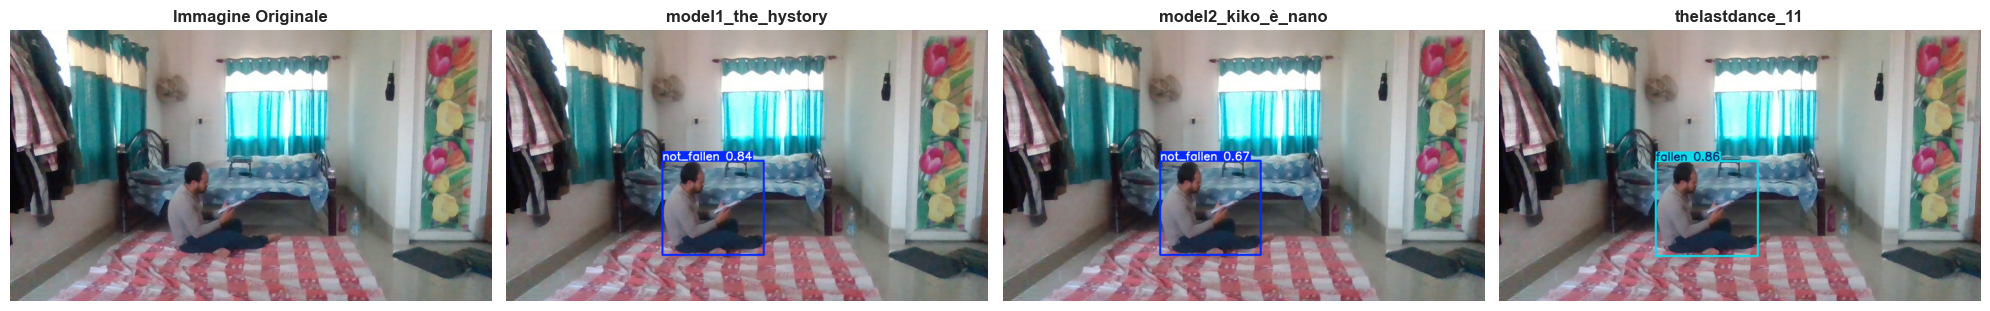


🖼️ Test visuale su: Subject 3_21_52.jpg

image 1/1 /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/augmented_yolo_dataset/images/test/Subject 3_21_52.jpg: 256x416 1 not_fallen, 22.4ms
Speed: 0.9ms preprocess, 22.4ms inference, 0.4ms postprocess per image at shape (1, 3, 256, 416)

image 1/1 /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/augmented_yolo_dataset/images/test/Subject 3_21_52.jpg: 384x640 1 not_fallen, 41.7ms
Speed: 1.4ms preprocess, 41.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/augmented_yolo_dataset/images/test/Subject 3_21_52.jpg: 384x640 1 not_fallen, 37.3ms
Speed: 1.2ms preprocess, 37.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


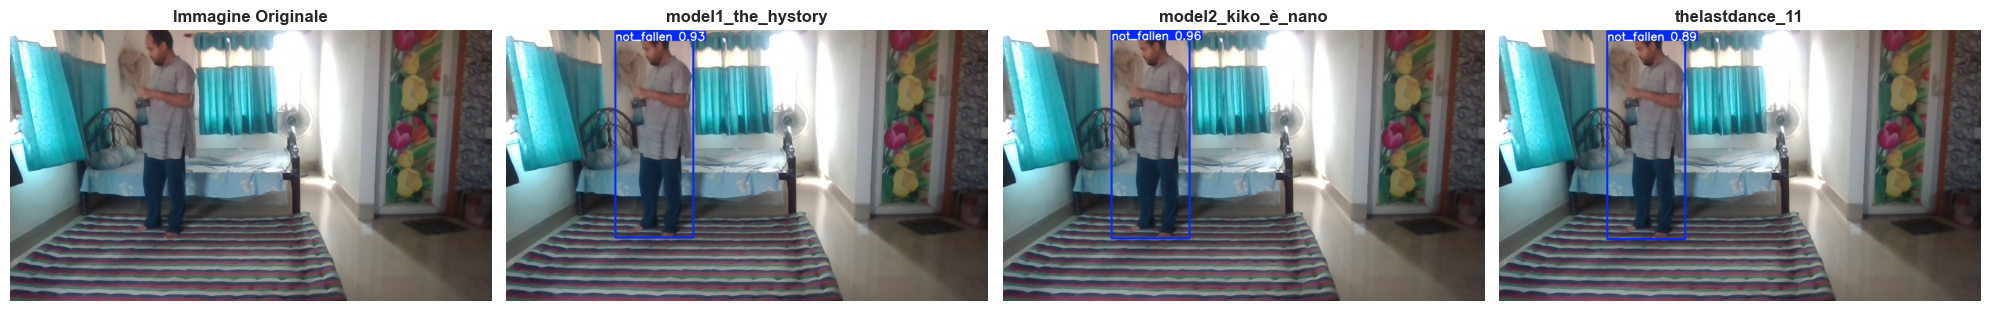


🖼️ Test visuale su: Subject 4_16_157.jpg

image 1/1 /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/augmented_yolo_dataset/images/test/Subject 4_16_157.jpg: 256x416 1 fallen, 25.0ms
Speed: 0.7ms preprocess, 25.0ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 416)

image 1/1 /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/augmented_yolo_dataset/images/test/Subject 4_16_157.jpg: 384x640 1 fallen, 41.4ms
Speed: 1.3ms preprocess, 41.4ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/augmented_yolo_dataset/images/test/Subject 4_16_157.jpg: 384x640 1 fallen, 40.8ms
Speed: 1.1ms preprocess, 40.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


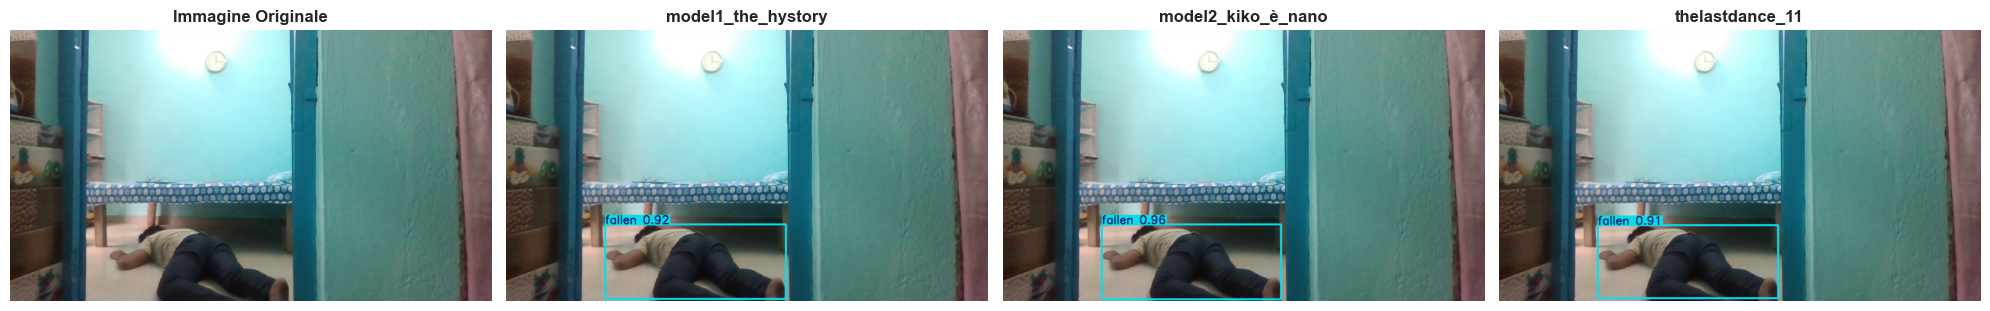

In [13]:
# %% [markdown]
# ## 11. Test Visuale su Immagini Campione

# %%
def visual_comparison(models_dict, test_image_path, conf=0.25):
    """Confronto visuale delle predizioni dei modelli su una stessa immagine"""
    
    fig, axes = plt.subplots(1, len(models_dict) + 1, figsize=(5*(len(models_dict)+1), 5))
    
    # Mostra immagine originale
    img = cv2.imread(test_image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[0].imshow(img_rgb)
    axes[0].set_title('Immagine Originale', fontweight='bold')
    axes[0].axis('off')
    
    # Predizioni per ogni modello
    for idx, (model_name, model_path) in enumerate(models_dict.items()):
        if Path(model_path).exists():
            model = YOLO(model_path)
            results = model.predict(source=test_image_path, conf=conf, save=False)
            
            # Visualizza risultato
            if results and results[0].plot() is not None:
                img_with_boxes = results[0].plot()
                axes[idx+1].imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
            else:
                axes[idx+1].imshow(img_rgb)
                axes[idx+1].text(0.5, 0.5, 'Nessun rilevamento', 
                               ha='center', va='center', transform=axes[idx+1].transAxes)
            
            axes[idx+1].set_title(f'{model_name}', fontweight='bold')
            axes[idx+1].axis('off')
    
    plt.tight_layout()
    return fig

# Test su alcune immagini campione
test_images = list(Path(CONFIG['test_data']['images_path']).glob('*.jpg'))[:3]

for i, test_img in enumerate(test_images):
    print(f"\n🖼️ Test visuale su: {test_img.name}")
    fig = visual_comparison(CONFIG['models'], str(test_img))
    fig.savefig(RESULTS_DIR / f'visual_comparison_{i+1}.png', dpi=150, bbox_inches='tight')
    plt.show()



In [14]:
# %% [markdown]
# ## 12. Salvataggio Risultati Finali

# %%
# Salva tutti i risultati in un unico file JSON
final_results = {
    'evaluation_date': datetime.now().isoformat(),
    'models_evaluated': list(CONFIG['models'].keys()),
    'test_dataset': CONFIG['test_data'],
    'comparison_table': df_comparison.to_dict('records'),
    'detailed_results': all_results,
    'winners': criteria if 'criteria' in locals() else {},
    'config': CONFIG
}

with open(RESULTS_DIR / 'complete_evaluation.json', 'w') as f:
    json.dump(final_results, f, indent=2, default=str)

print(f"\n✅ Tutti i risultati salvati in: {RESULTS_DIR}")
print("\n📁 File generati:")
for file in sorted(RESULTS_DIR.glob('*')):
    print(f"   • {file.name}")

# %% [markdown]
# ## 🎯 Conclusioni e Prossimi Passi
# 
# Basandoti sui risultati:
# 
# 1. **Scegli il modello più adatto** al tuo caso d'uso
# 2. **Ottimizza ulteriormente** il modello scelto se necessario
# 3. **Testa su nuovi dati** per validare le performance
# 4. **Considera ensemble methods** se hai risorse sufficienti
# 
# ### Quick Test Function

# %%
def quick_test(image_path, model_name=None):
    """Test rapido con il modello migliore o specificato"""
    
    if model_name is None:
        # Usa il modello con miglior trade-off
        model_name = criteria.get('Miglior Trade-off', list(CONFIG['models'].keys())[0])
    
    model_path = CONFIG['models'].get(model_name)
    
    if model_path and Path(model_path).exists():
        print(f"🔍 Testing con {model_name}")
        model = YOLO(model_path)
        results = model.predict(source=image_path, conf=0.25, save=True)
        
        # Mostra risultati
        for r in results:
            if r.boxes is not None:
                for box in r.boxes:
                    cls = int(box.cls)
                    conf = float(box.conf)
                    print(f"   • Rilevato: {CONFIG['class_names'][cls]} (conf: {conf:.2%})")
        
        return results
    else:
        print(f"❌ Modello {model_name} non trovato")
        return None

# Esempio:
# results = quick_test('path/to/new/image.jpg')


✅ Tutti i risultati salvati in: model_evaluation_results

📁 File generati:
   • complete_evaluation.json
   • confusion_matrices.png
   • evaluation_report.txt
   • model1_the_hystory_evaluation.json
   • model2_kiko_è_nano_evaluation.json
   • model_comparison.csv
   • model_comparison_plots.png
   • radar_comparison.png
   • thelastdance_11_evaluation.json
   • visual_comparison_1.png
   • visual_comparison_2.png
   • visual_comparison_3.png
